In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import panel as pn
from panel.interact import interact
pn.extension()

### Define the fitting models

In [2]:
# Define a general hyperbolic tangent model
def area_tanh(t, a, b, c, d):
    """
    t: time
    a,b,c,d: constants to be fitted
    """
    return a*np.tanh(b*(t-c))+d

def der1_area_tanh(t, a, b, c):
    """
    t: time
    a,b,c,d: constants to be fitted
    """
    return a*b * (1 - (np.tanh(b*(t-c)))**2)

def der2_area_tanh(t, a, b, c):
    """
    t: time
    a,b,c,d: constants to be fitted
    """
    tanh = np.tanh(b*(t-c))
    return -2*a*(b**2) * tanh * (1 - tanh**2)


# Define the logistic growth rate model
def area_logistic(t, a0, r, k):
    """
    t  :time
    a0 : area at time zer0
    r  : growth rate
    k  : carrying capacity
    """
    return k / (1 + (k/a0 - 1)*np.exp(-r*t))

def der1_area_logistic(t, a0, r, k):
    """
    t  :time
    a0 : area at time zer0
    r  : growth rate
    k  : carrying capacity
    """
    cexp = (k/a0 - 1)*np.exp(-r*t)
    return r*k*cexp / (1 + cexp)**2

def der2_area_logistic(t, a0, r, k):
    """
    t  :time
    a0 : area at time zer0
    r  : growth rate
    k  : carrying capacity
    """
    cexp = (k/a0 - 1)*np.exp(-r*t)
    return (r**2)*k*cexp* (cexp - 1) / (1 + cexp)**3

### Read the data frame and show a summary of the growth curves and the fitting models

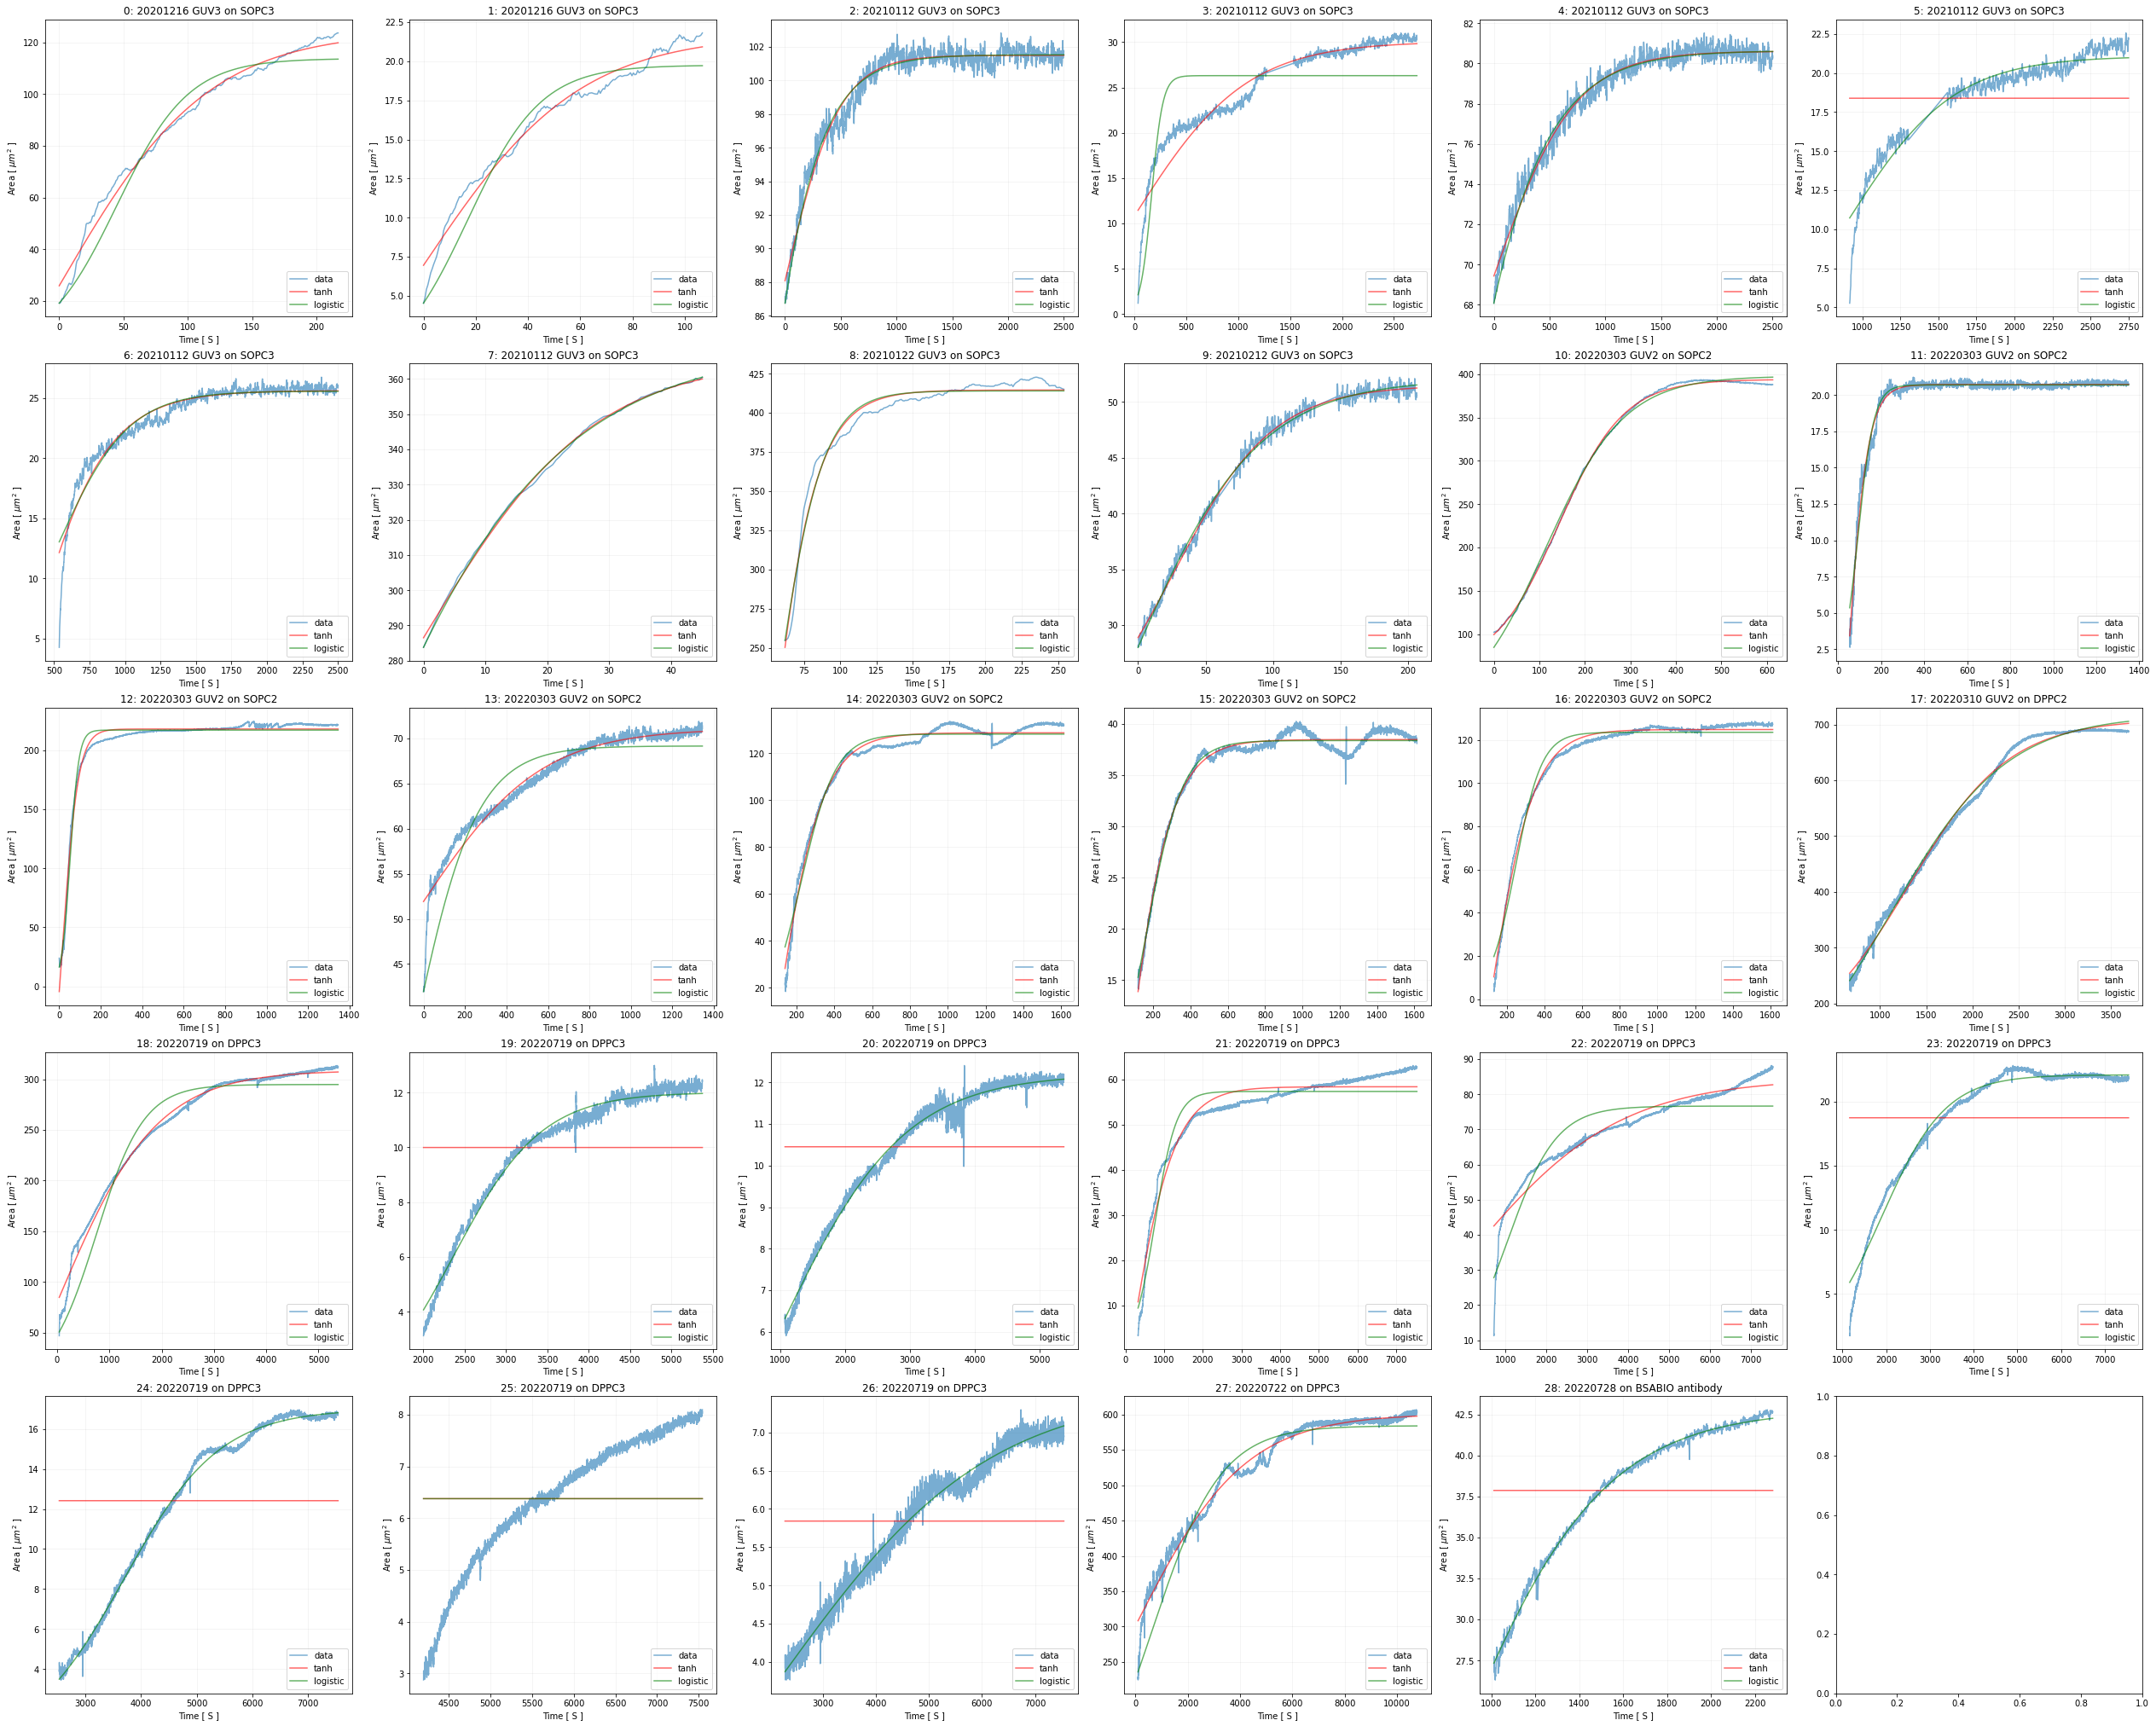

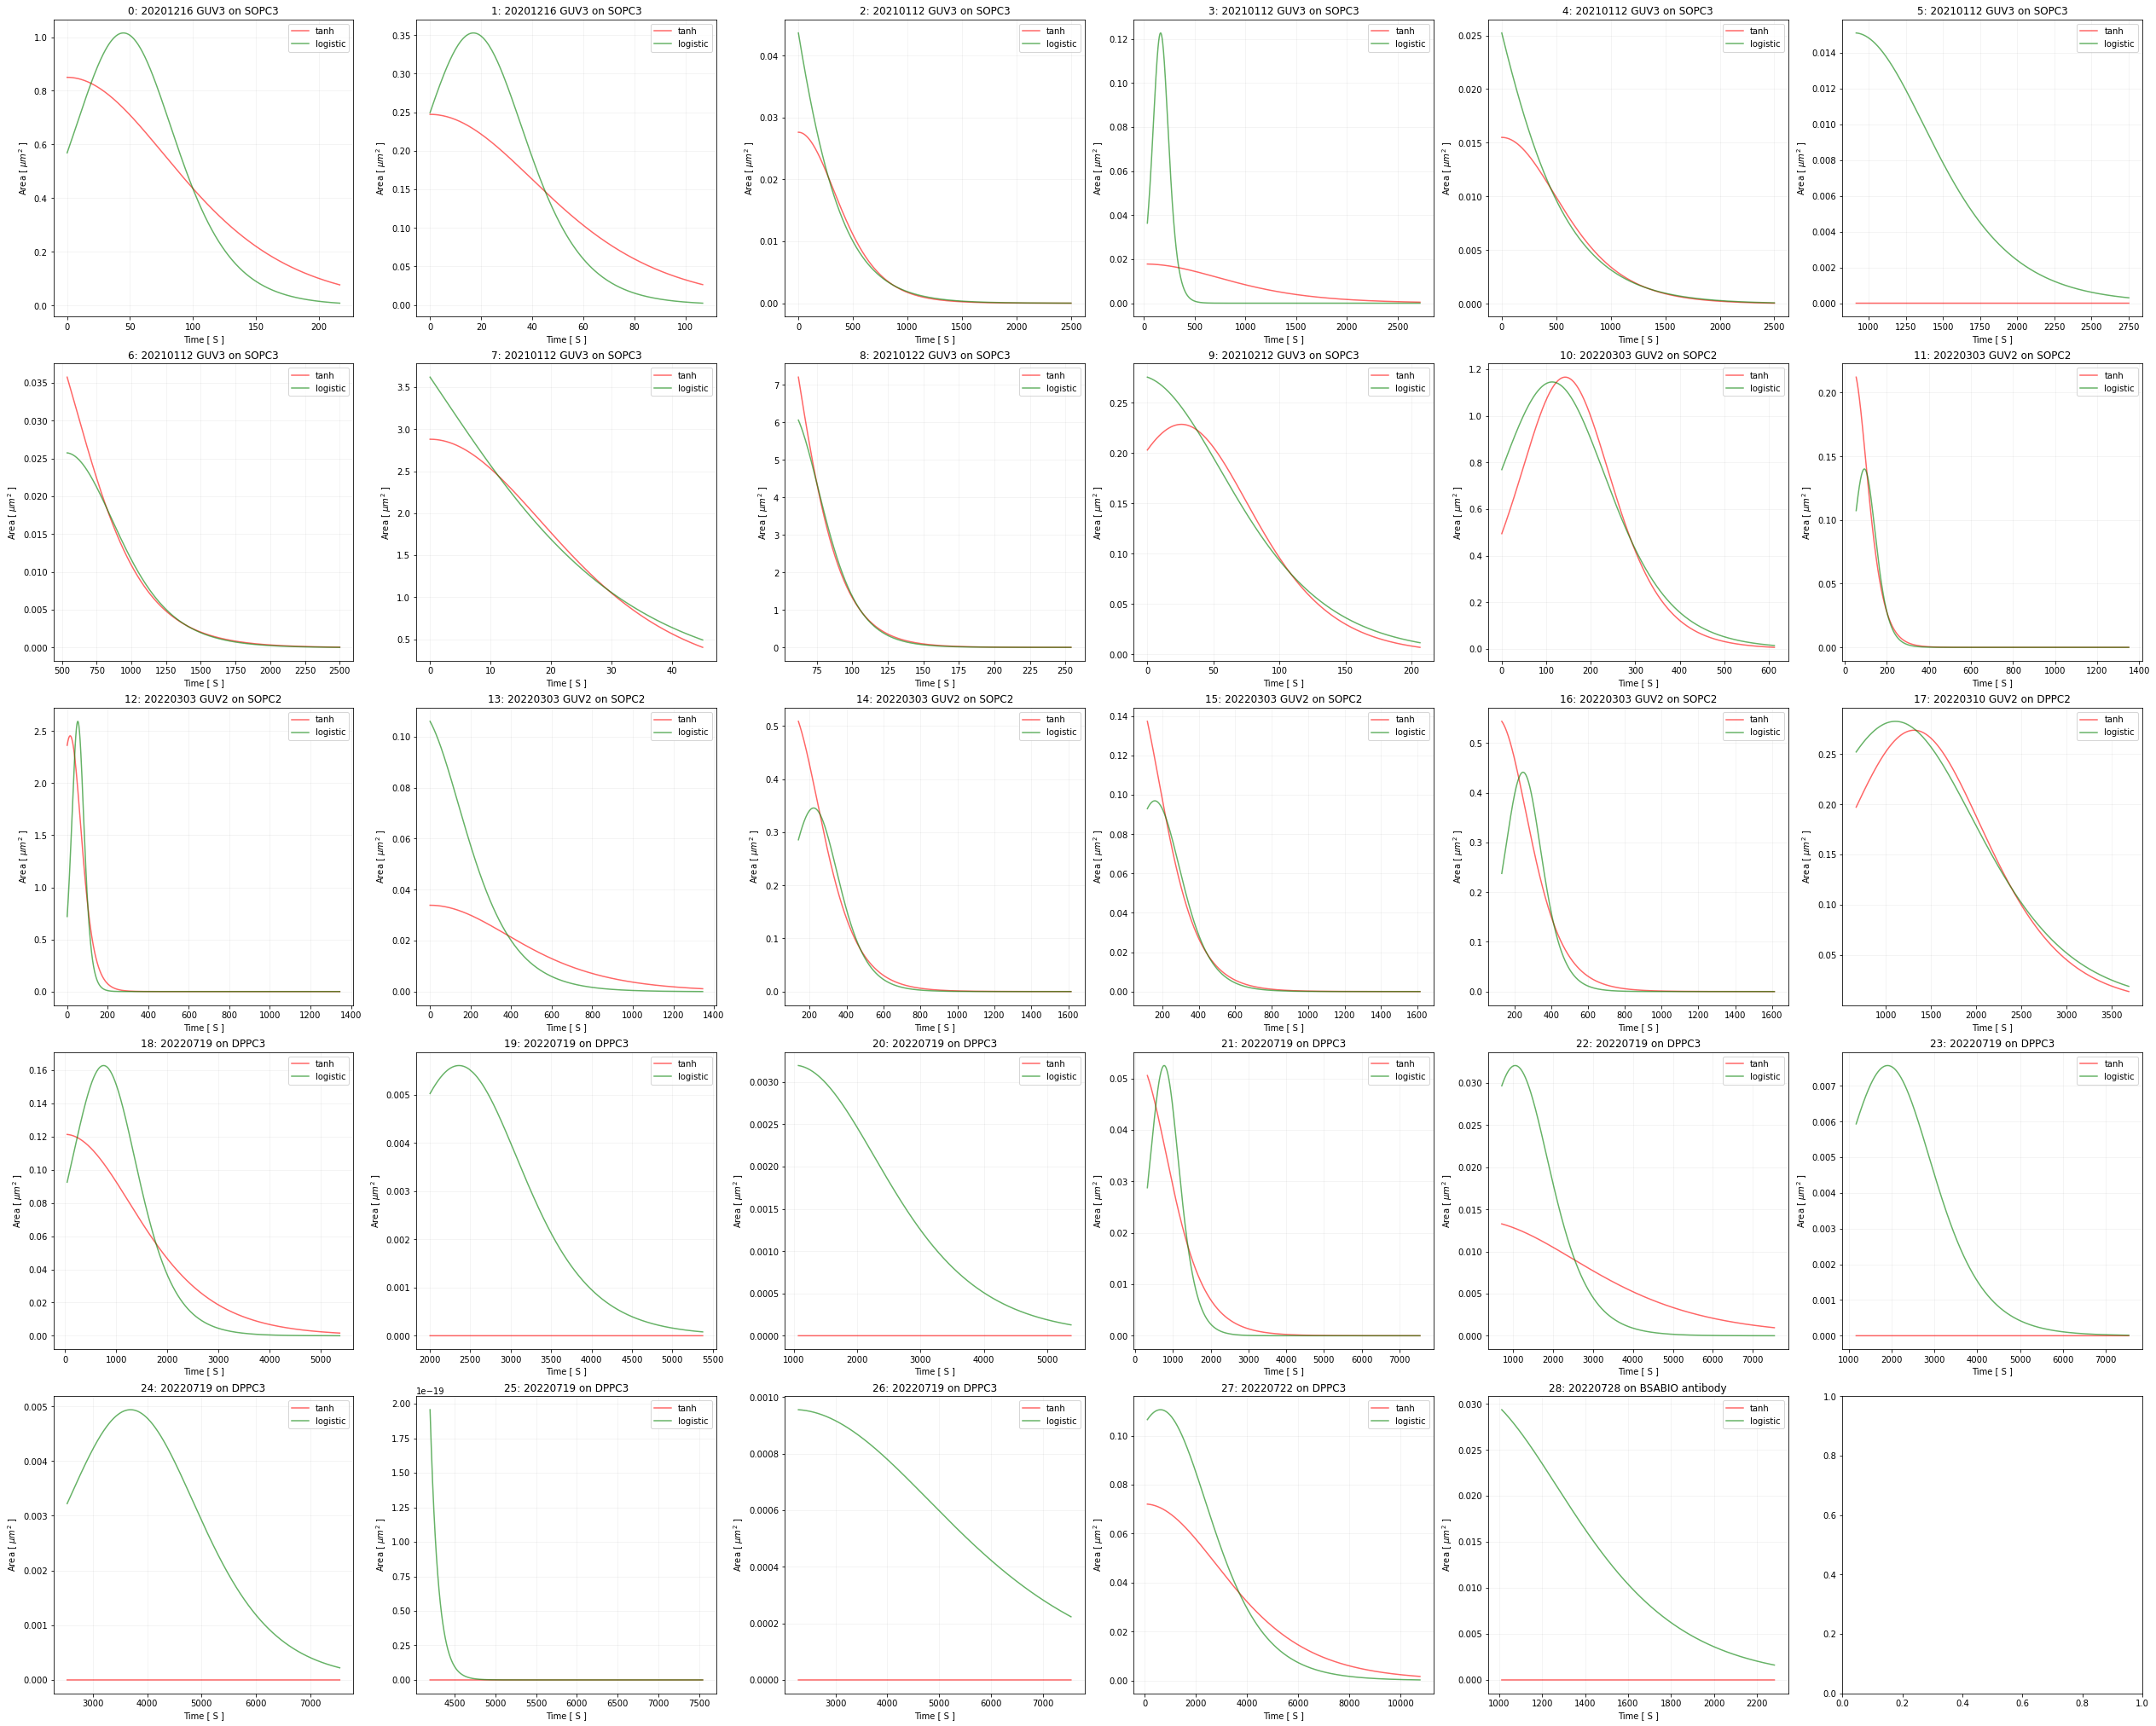

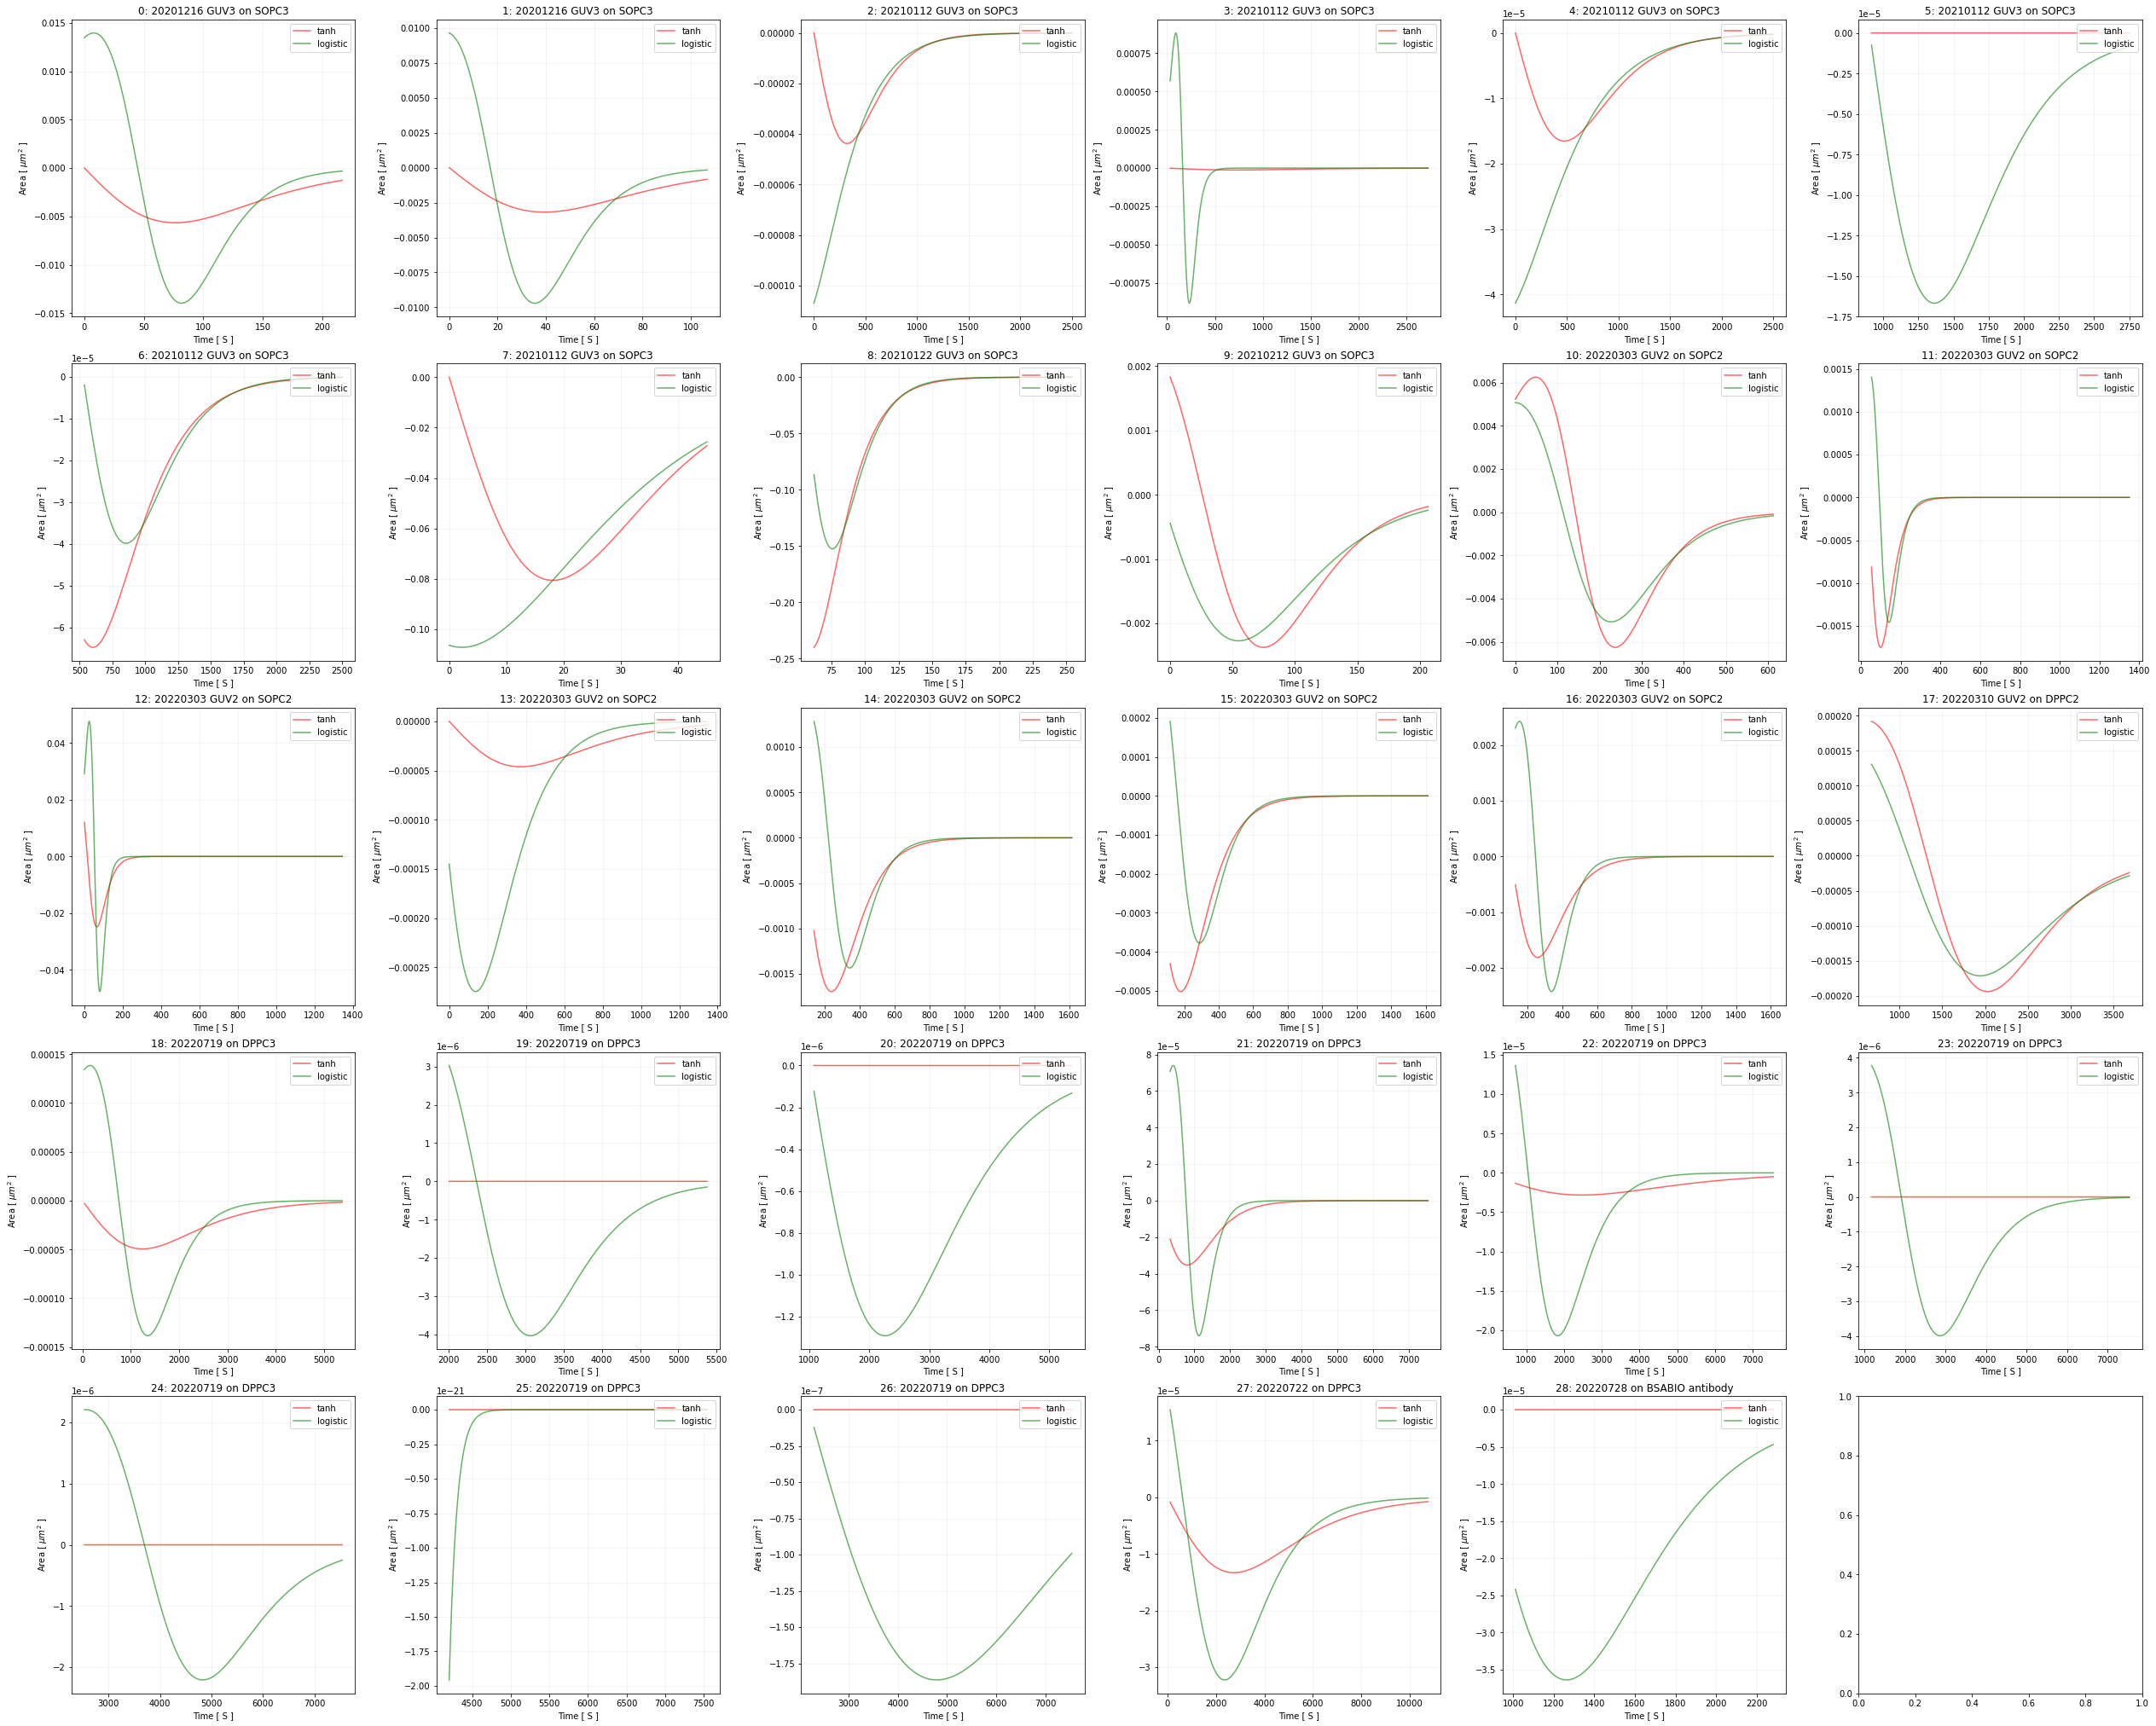

In [3]:
# Read the area curves table
df = pd.read_pickle('Results/manipulated_area_curves.pkl')

parameters_tanh, parameters_logistic = [], []
for i in range(df.shape[0]):
    # Read the time and area
    t, A = df['Time'][i], df['Area'][i]
    
    # Compute the maximum and minimum of the area
    area_max = np.max(A)
    area_min = np.min(A)
    
    # Fit a general tanh function to the curves a*np.tanh(b*(t-c))+d with parameters a, b, c, d
    popt_tanh, _ = curve_fit(area_tanh, t, A,
                             p0=(area_max-area_min, 0.01, 0, 0),
                             bounds=([0, 0.0001, 0, -area_max], [area_max, 1, t[-1], 2.5*area_max]))
    parameters_tanh.append(popt_tanh)
                   
    # Fit a logistic growth function to the curves  k / (1 + (k/a0 - 1)*np.exp(-r*t)) with parameters a0, r, k
    popt_logistic, _ = curve_fit(area_logistic, t, A,
                                 p0=(1, 0.01, area_max),
                                 bounds=([0.1, 0.0001, area_min], [area_min, 1, 2*area_max]))
    parameters_logistic.append(popt_logistic)
    
    # Define the figure size only once
    if i==0: plt.subplots(5,6, figsize=(35, 28), constrained_layout=True)
    
    plt.subplot(5, 6, i+1)
    plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
    plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')                # tanh
    plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right')
    
plt.savefig('Results/area_curves_2')
plt.show()


# Draw the derivative curves
for i in range(df.shape[0]):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.subplots(5,6, figsize=(35, 28), constrained_layout=True)
    
    plt.subplot(5, 6, i+1)
    plt.plot(t, der1_area_tanh(t, *parameters_tanh[i][:-1]), label='tanh', alpha = 0.6, color= 'r')           # tanh
    plt.plot(t, der1_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_2_der1')
plt.show()

# Draw the second derivative curves
for i in range(df.shape[0]):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.subplots(5,6, figsize=(35, 28), constrained_layout=True)
    
    plt.subplot(5, 6, i+1)
    plt.plot(t, der2_area_tanh(t, *parameters_tanh[i][:-1]), label='tanh', alpha = 0.6, color= 'r')           # tanh
    plt.plot(t, der2_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_2_der2')
plt.show()

### Decrease the sigmas on the begining and ending of the curve

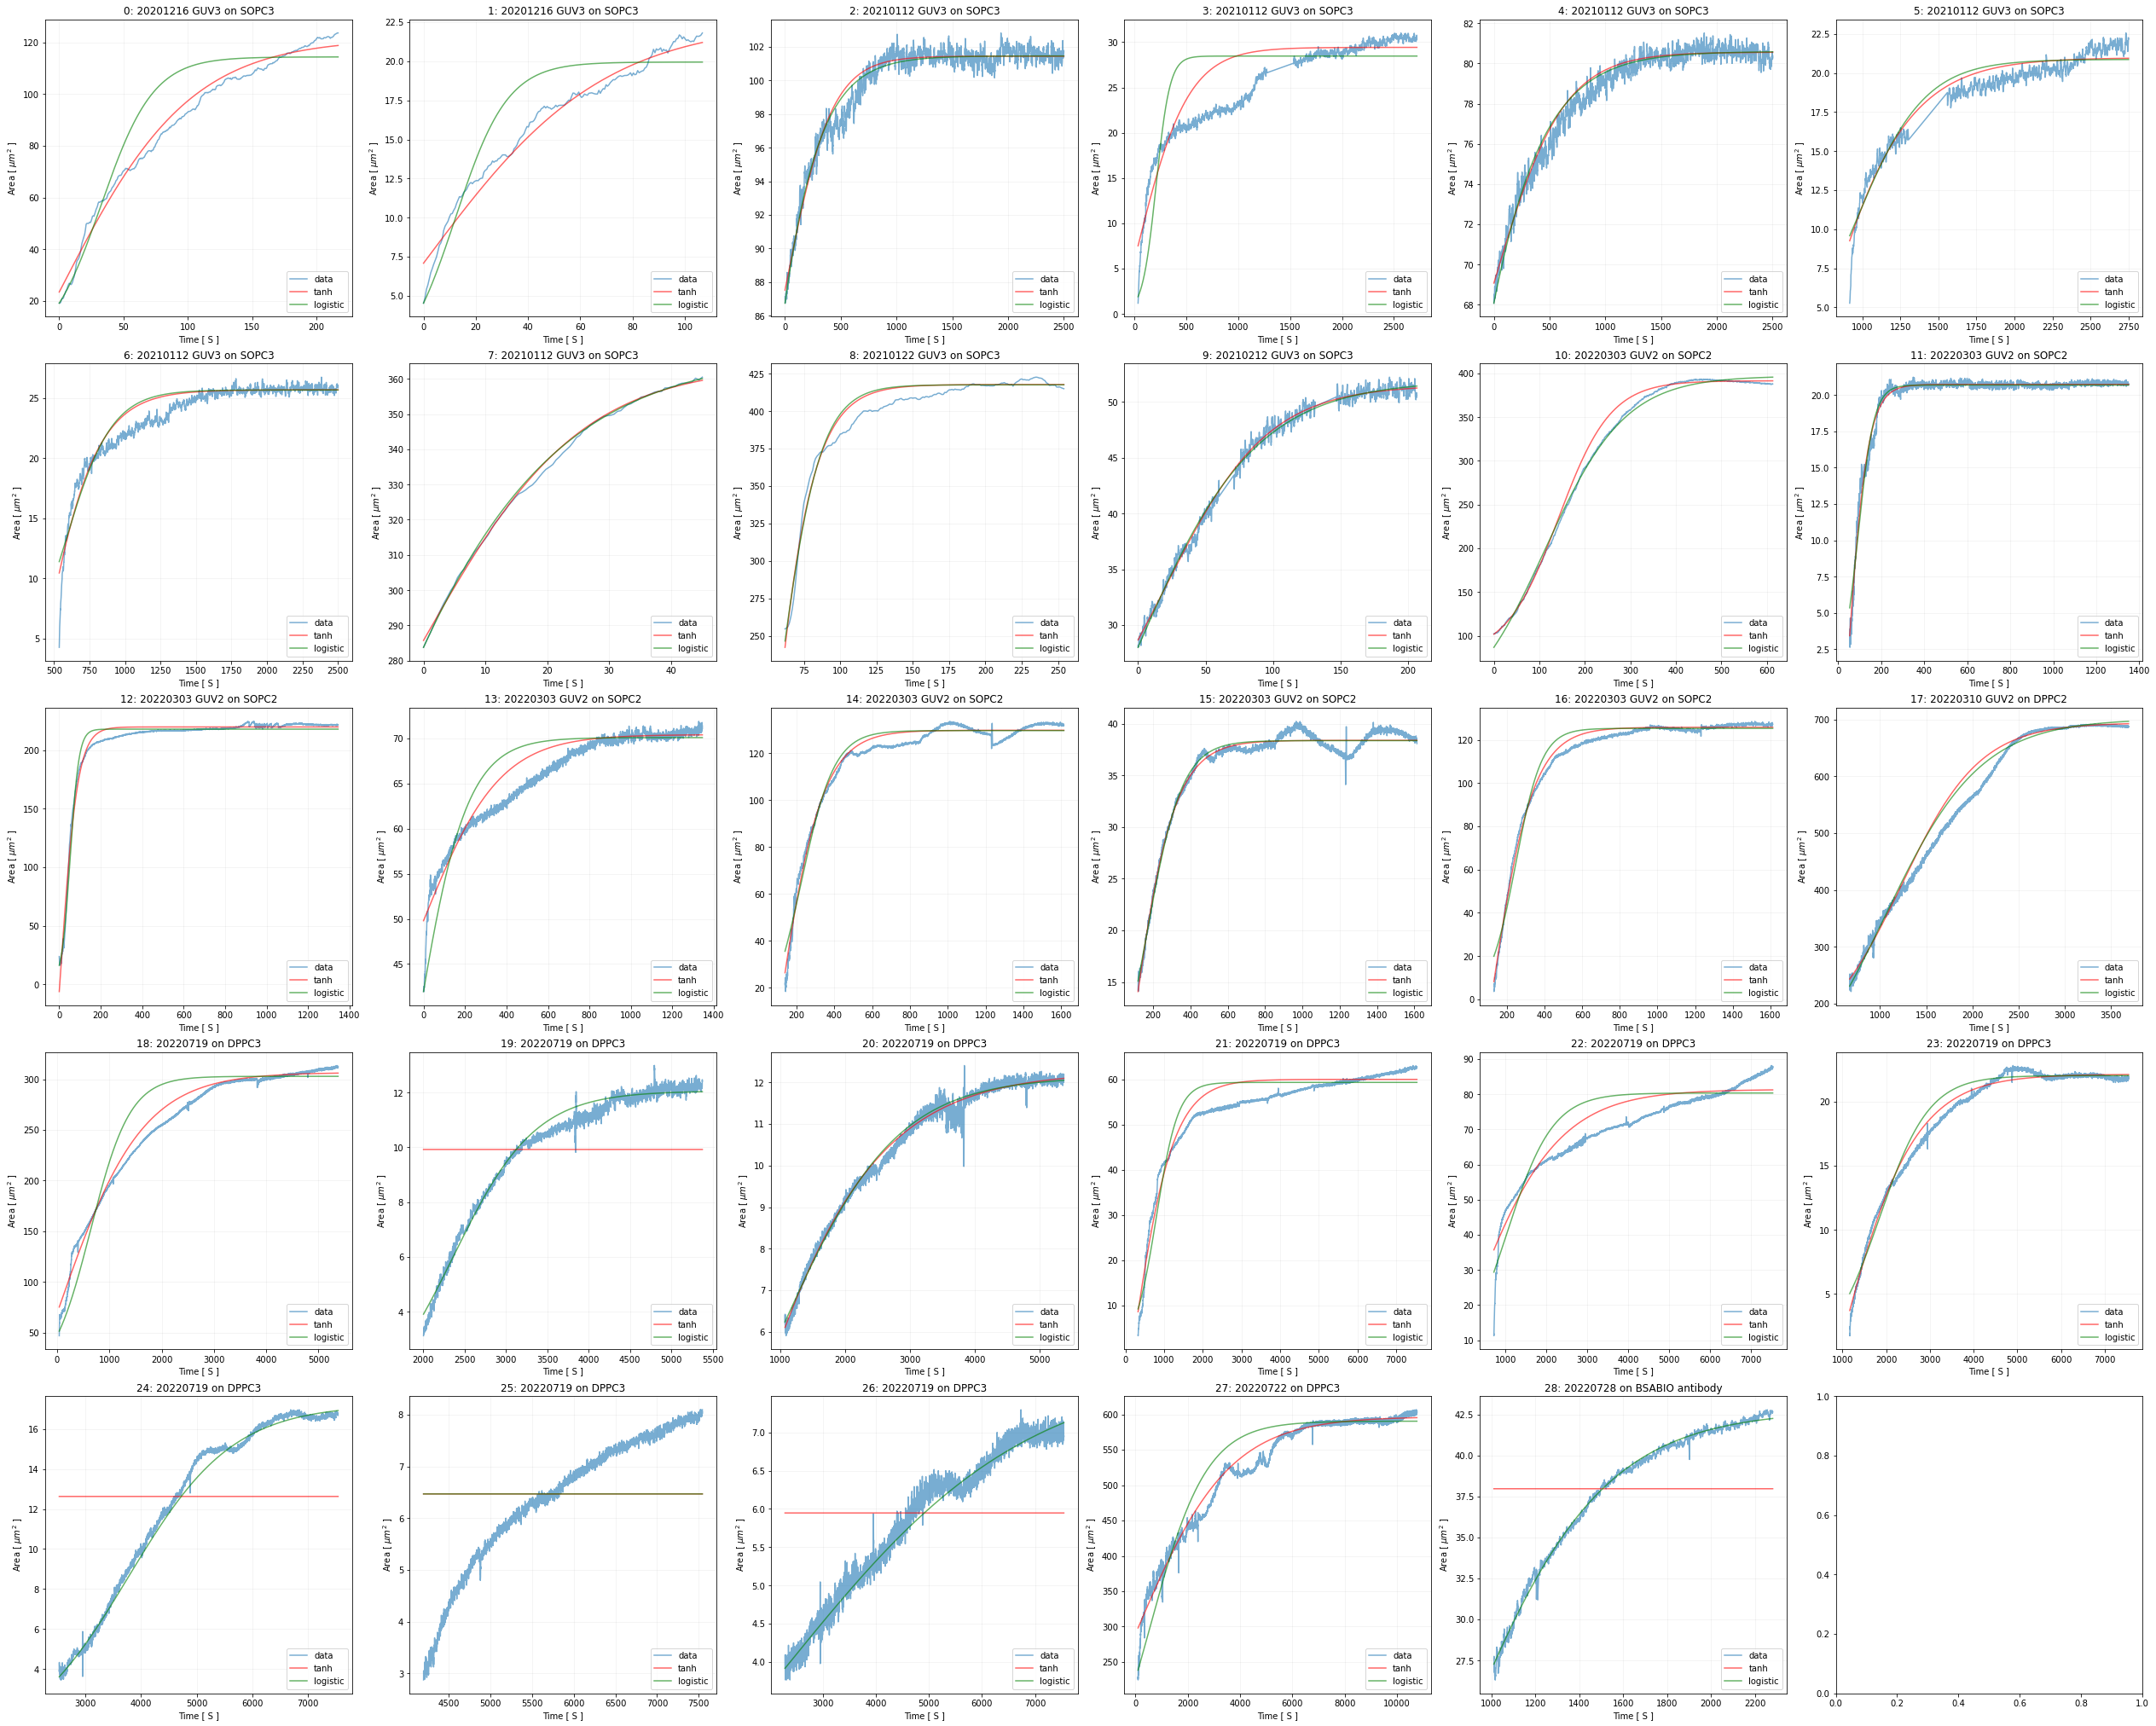

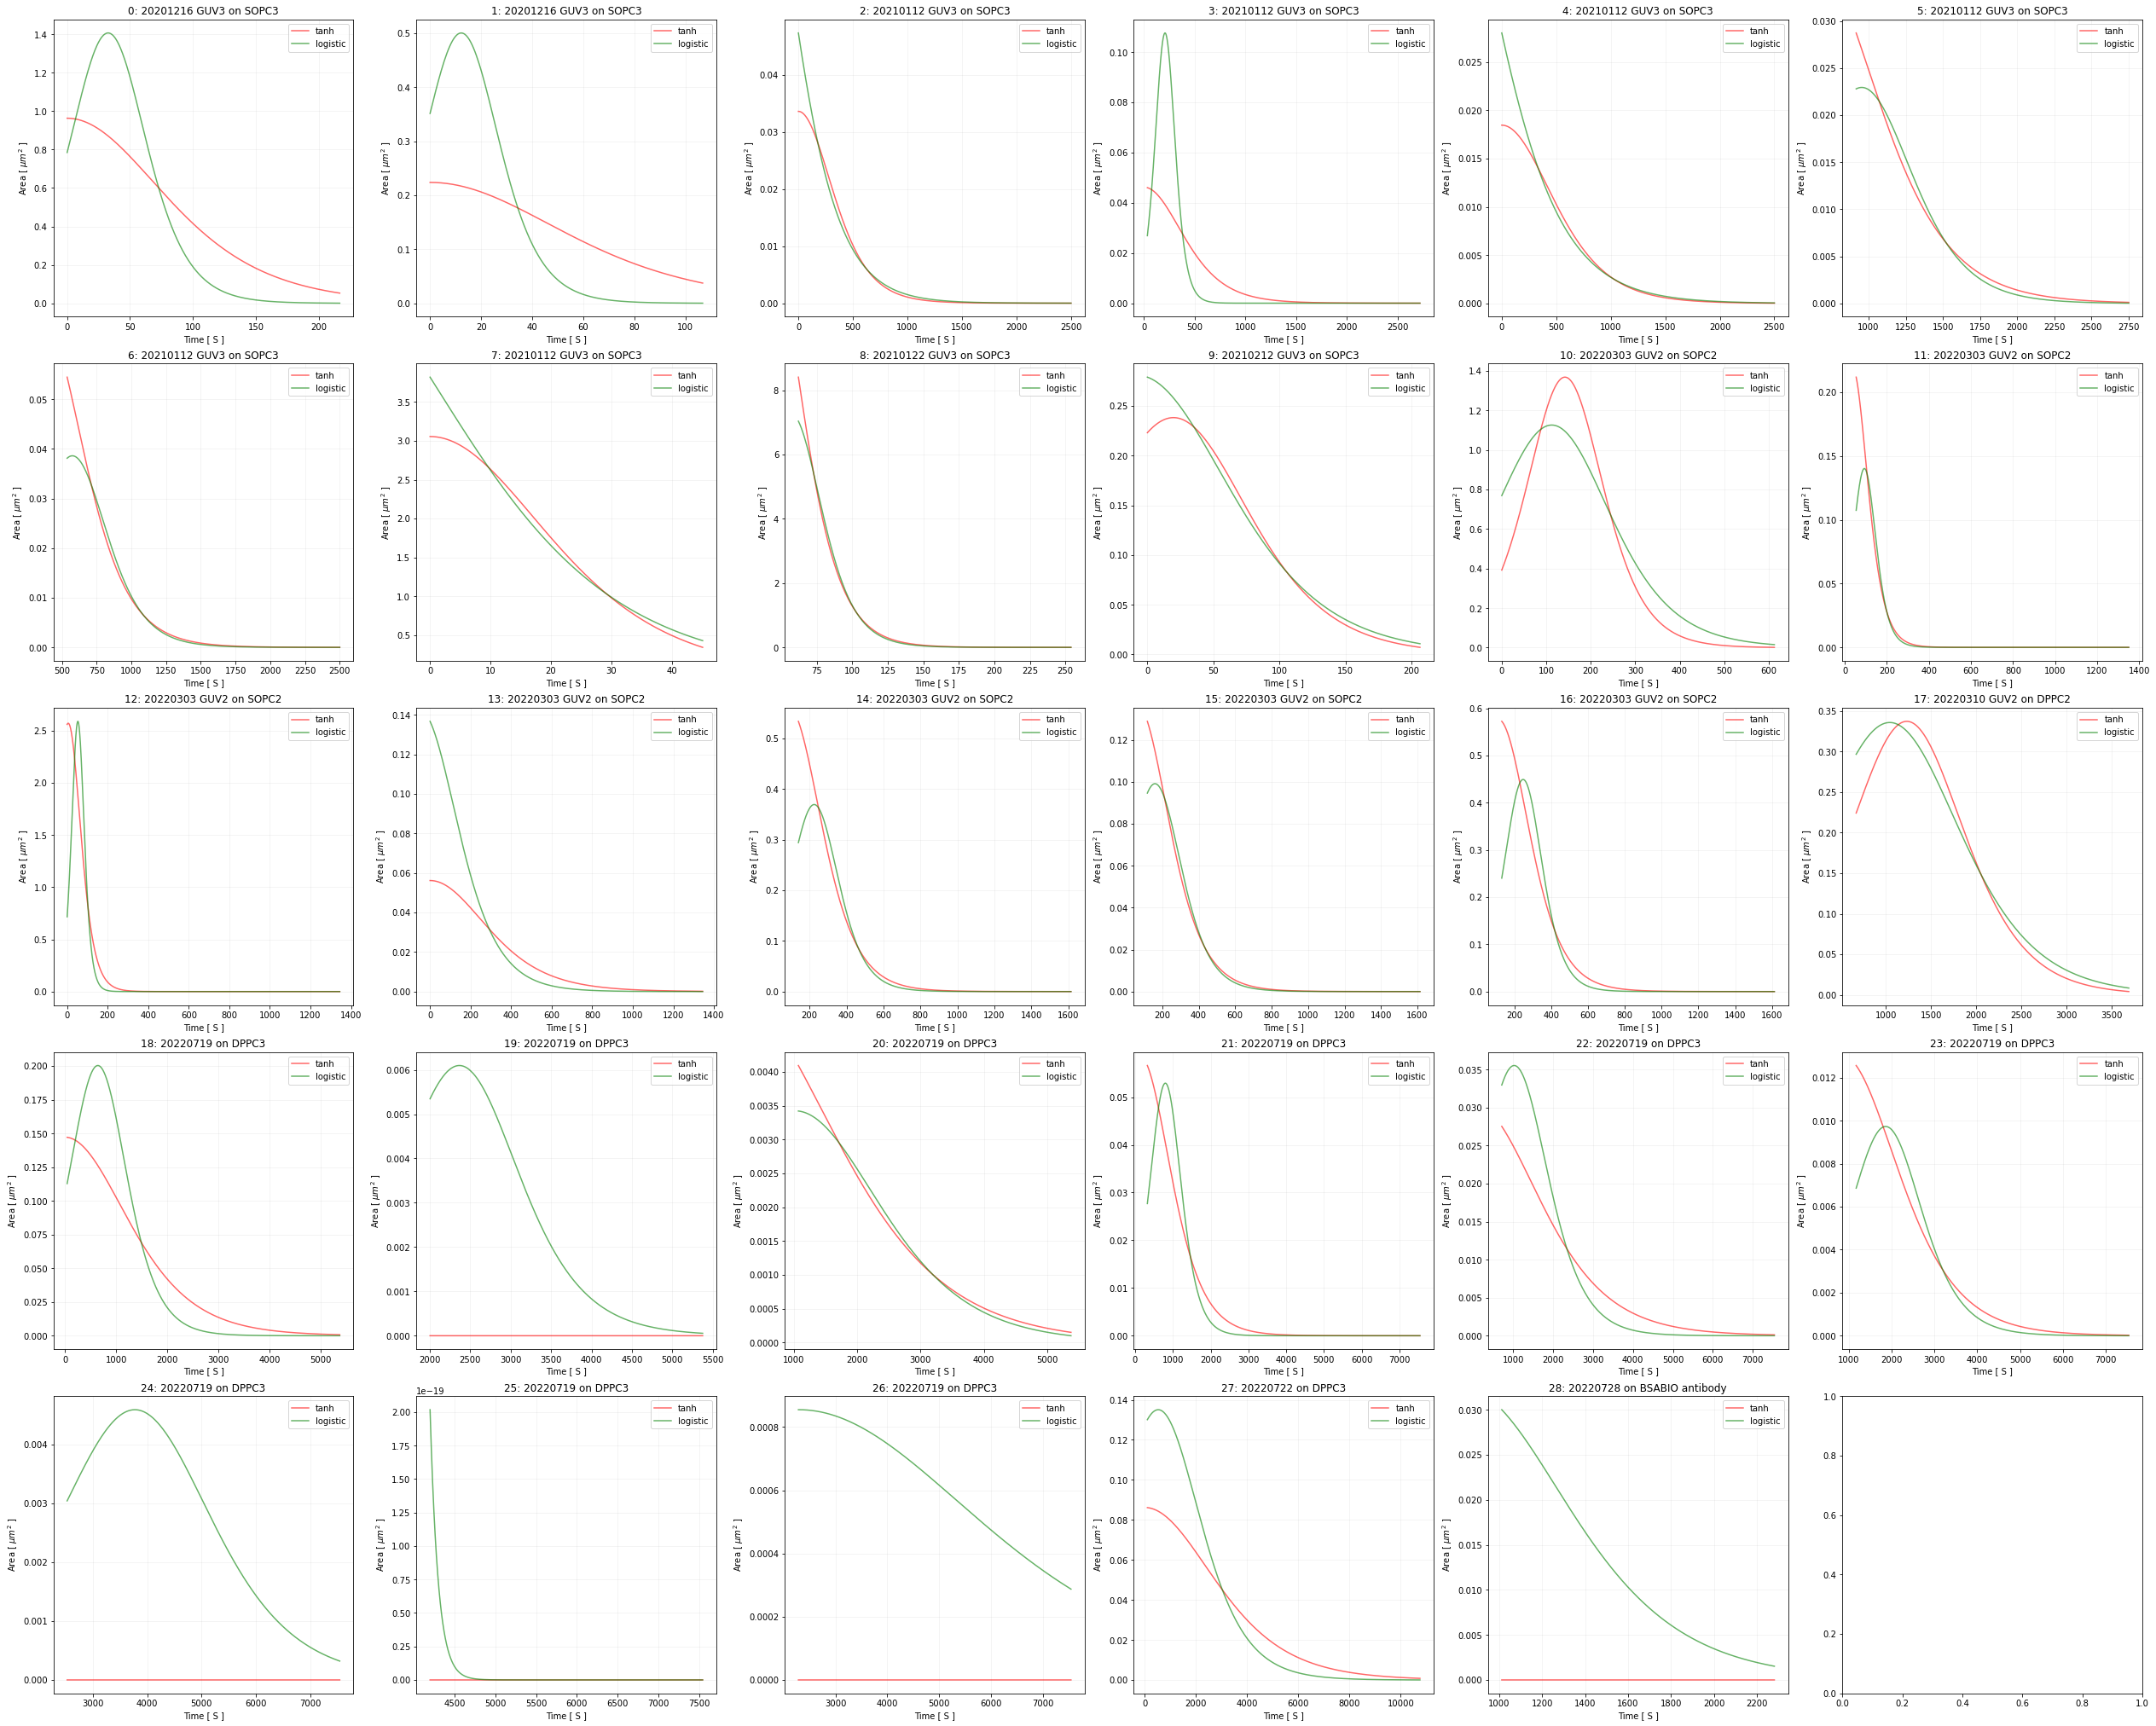

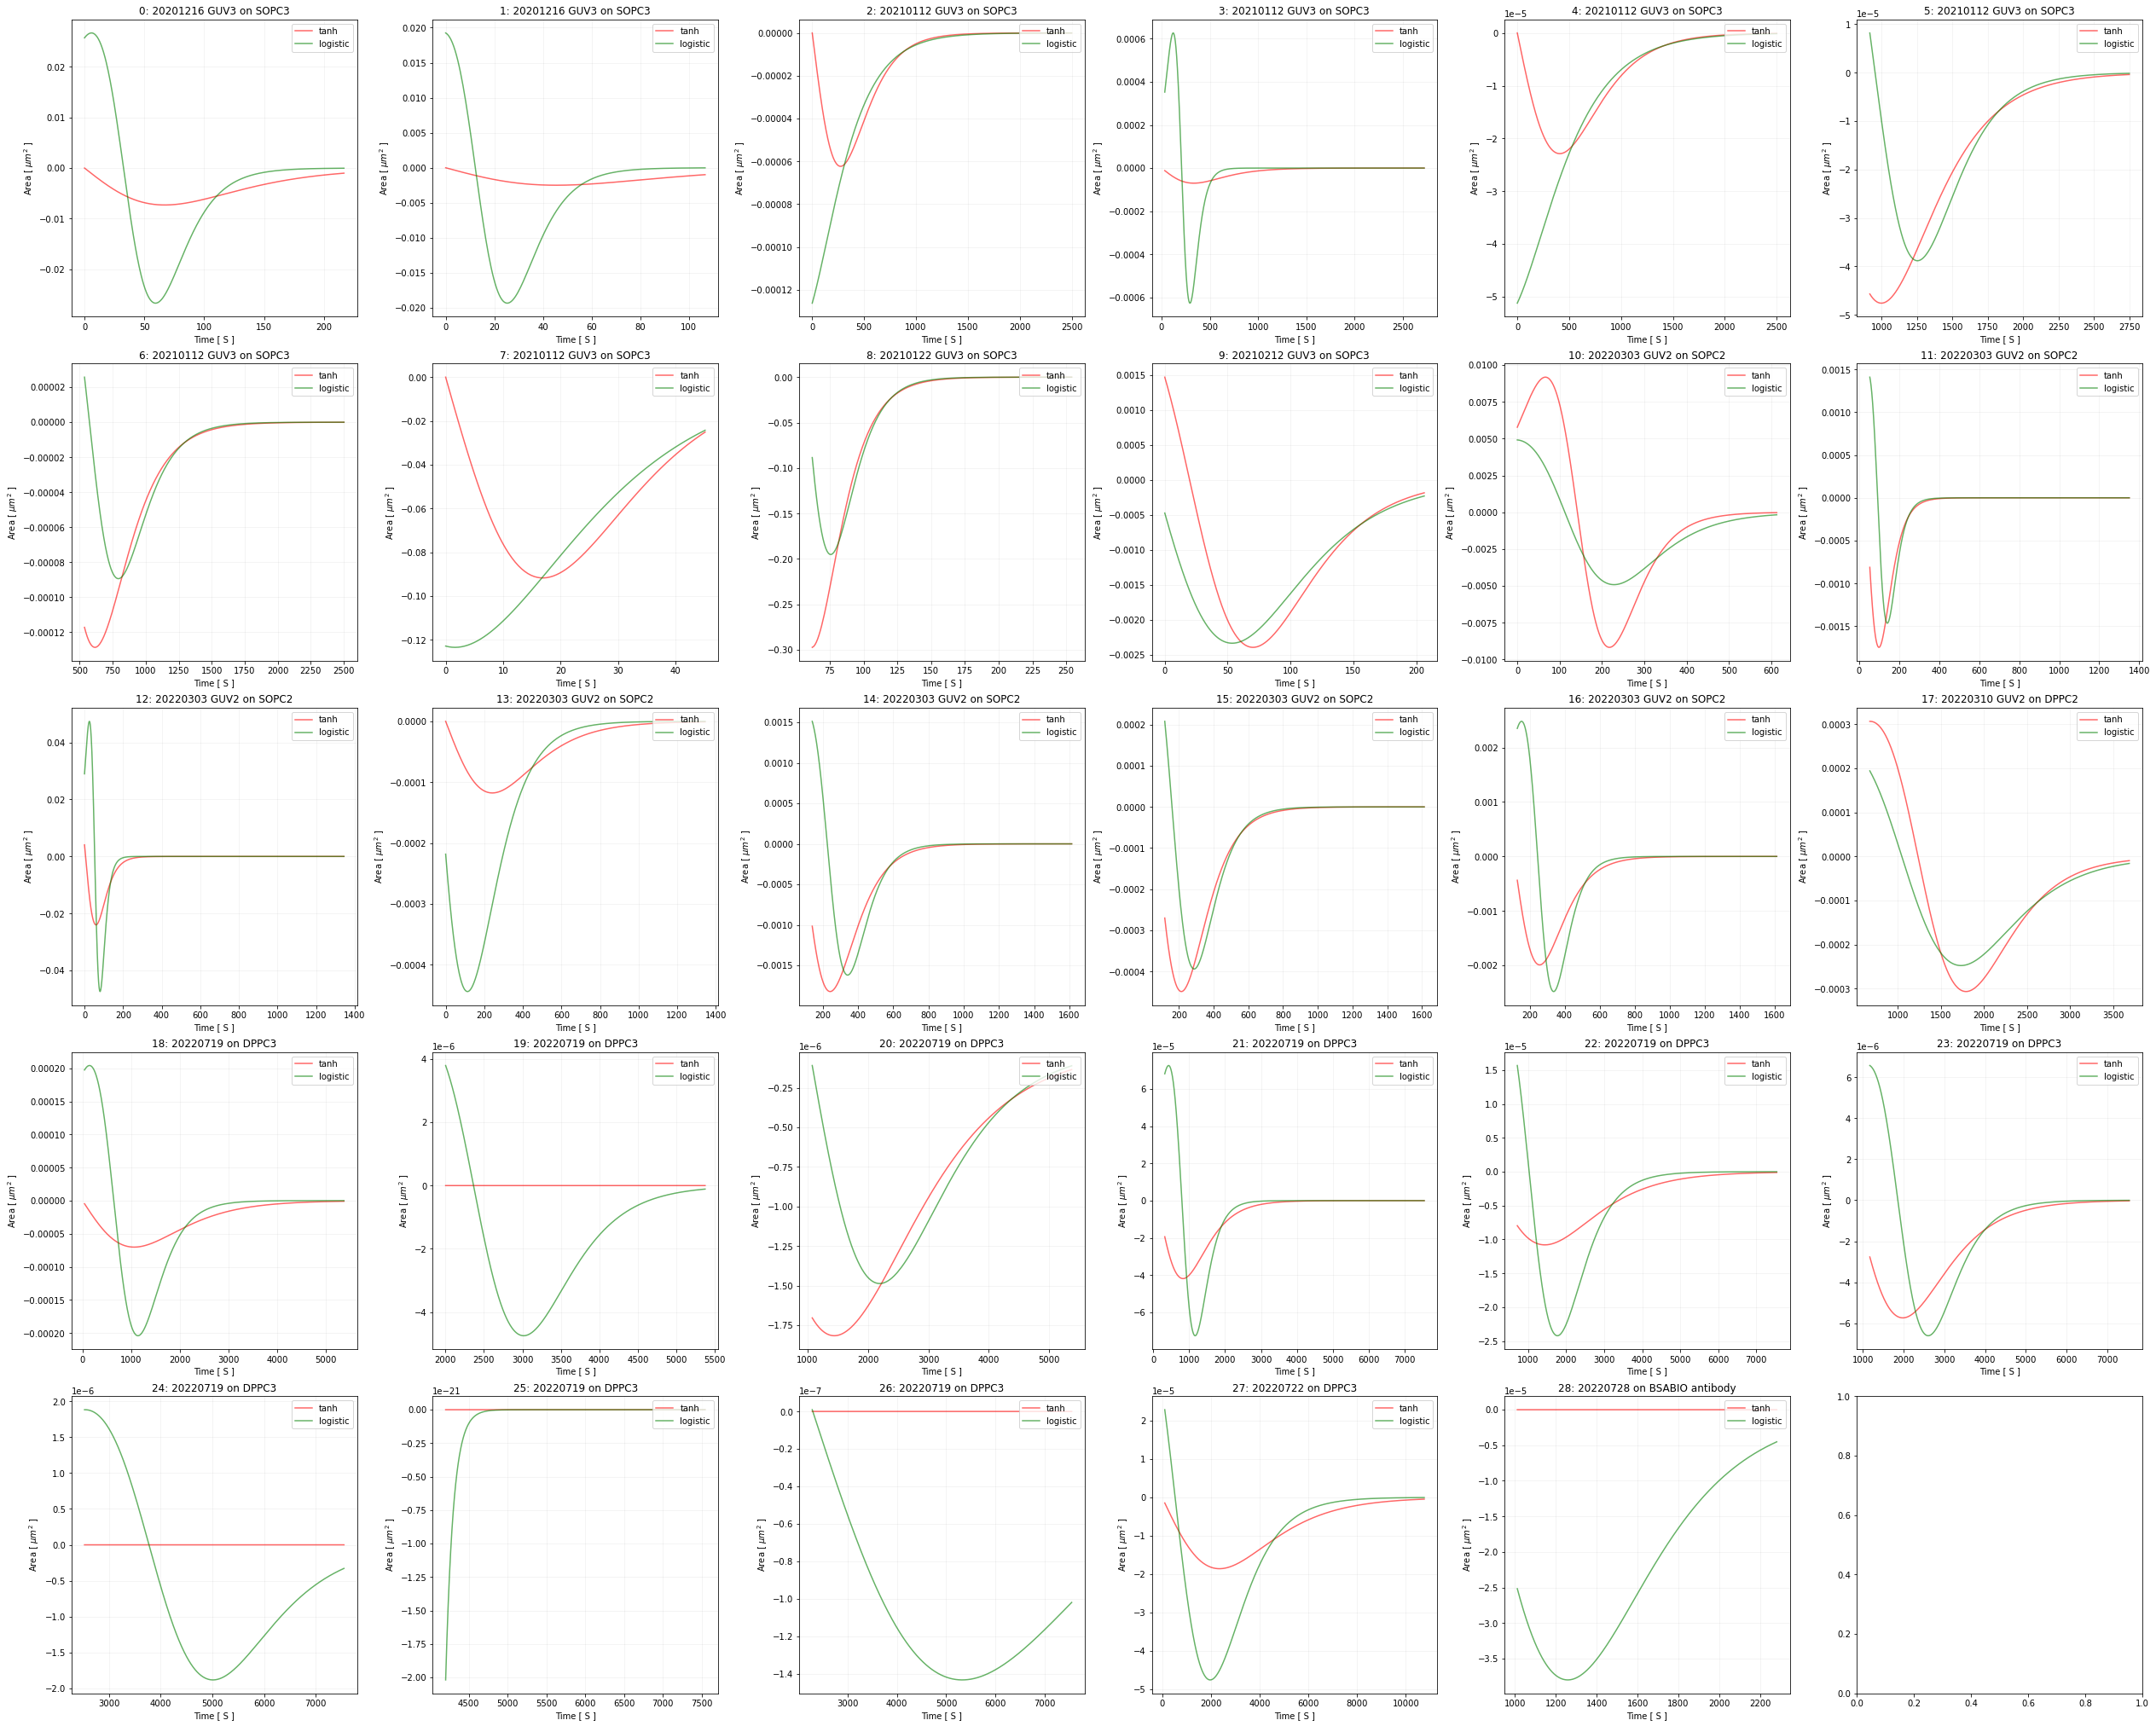

In [4]:
df = pd.read_pickle('Results/manipulated_area_curves.pkl')

parameters_tanh, parameters_logistic = [], []
for i in range(df.shape[0]):
    # Read the time and area
    t, A = df['Time'][i], df['Area'][i]
    
    # Create an array of weights
    l = t.shape[0]
    sigmas = np.ones(l) * (np.max(A)/100)
    
    sigmas[:l//5] = sigmas[:l//5] * 0.1
    sigmas[l-2*l//5:] = sigmas[l-2*l//5:] * 0.1
    sigmas[l//5:l-2*l//5] = sigmas[l//5:l-2*l//5] * 3
    
    # Fit a general tanh function to the curves 
    popt_tanh, _ = curve_fit(area_tanh, t, A, sigma=sigmas,
                             p0=(np.max(A)-np.min(A), 0.01, 0, 0),
                             bounds=([0, 0.0001, 0, -np.max(A)], [np.max(A), 1, t[-1], 1.5*np.max(A)]))
    parameters_tanh.append(popt_tanh)
                   
    # Fit a general tanh function to the curves 
    popt_logistic, _ = curve_fit(area_logistic, t, A, sigma=sigmas,
                                 p0=(1, 0.01, np.max(A)),
                                 bounds=([0.1, 0.0001, np.min(A)], [np.min(A), 1, 2*np.max(A)]))
    parameters_logistic.append(popt_logistic)
    
    # Define the figure size only once
    if i==0: plt.subplots(5,6, figsize=(35, 28), constrained_layout=True)
    
    plt.subplot(5, 6, i+1)
    plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
    plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')                # tanh
    plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right')

# Save and show the figure
plt.savefig('Results/area_curves_with_weights_2')
plt.show()


# Draw the first derivative curves
for i in range(df.shape[0]):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.subplots(5,6, figsize=(35, 28), constrained_layout=True)
    
    plt.subplot(5, 6, i+1)
    plt.plot(t, der1_area_tanh(t, *parameters_tanh[i][:-1]), label='tanh', alpha = 0.6, color= 'r')           # tanh
    plt.plot(t, der1_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_with_weights_2_der1')
plt.show()


# Draw the second derivative curves
for i in range(df.shape[0]):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.subplots(5,6, figsize=(35, 28), constrained_layout=True)
    
    plt.subplot(5, 6, i+1)
    plt.plot(t, der2_area_tanh(t, *parameters_tanh[i][:-1]), label='tanh', alpha = 0.6, color= 'r')           # tanh
    plt.plot(t, der2_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_with_weights_2_der2')
plt.show()

### Save the parameters to the data frame

In [23]:
# Save the initial data frame with proper name
df.to_pickle('Results/manipulated_area_curves_2.pkl')

# Add columns for the model to the data frame
df['Model_tanh'] = parameters_tanh
df['Model_logistic'] = parameters_logistic

# Save the results data frame as pickle
df.to_pickle('Results/result_area_curves_2.pkl')

# Save a csv and excel to be used out of python
df.drop(['Time', 'Area'], axis=1).to_csv('Results/result_area_curves_2.csv', index=False)
df.drop(['Time', 'Area'], axis=1).to_excel('Results/result_area_curves_2.xlsx', index=False)

df

,Date,Protein,Discription,Name,Time,Area,Model_tanh,Model_logistic
0,20201216,Mouse Ecad,GUV3 on SOPC3,Calib_camera1and2-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[19.203125, 19.15625, 19.484375, 20.359375, 20...","[98.04017828133955, 0.009826478857696903, 2.34...","[19.15624999999978, 0.049222446827517266, 114...."
1,20201216,Mouse Ecad,GUV3 on SOPC3,Calib_camera3-3,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[4.53125, 4.859375, 5.40625, 5.6875, 6.078125,...","[15.465193440691674, 0.01447060026004425, 9.41...","[4.531249999999998, 0.10035821983956589, 19.95..."
2,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[87.140625, 86.953125, 86.765625, 86.75, 86.93...","[13.918857790561994, 0.0024118551652516336, 1....","[86.74999999999999, 0.0037602159757118246, 101..."
3,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-2,"[33.0, 33.55, 34.1, 34.65, 35.2, 35.75, 36.3, ...","[1.1875, 1.28125, 1.25, 1.59375, 1.765625, 2.0...","[23.43019500633042, 0.001972098975607101, 1.03...","[1.1874999999999998, 0.01512601094580752, 28.4..."
4,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-3,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[68.078125, 68.203125, 68.515625, 68.34375, 68...","[11.481296589342275, 0.0016088310721738917, 6....","[68.07812499999996, 0.002650854418920511, 80.5..."
5,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-4,"[916.0, 917.0, 918.0, 919.0, 920.0, 921.0, 922...","[5.265625, 5.40625, 5.515625, 5.875, 6.0625, 6...","[22.562499999999996, 0.0016552619475498306, 59...","[0.3108843260300145, 0.004397280896618316, 20...."
6,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-5,"[537.0, 538.0, 539.0, 540.0, 541.0, 542.0, 543...","[4.265625, 4.859375, 5.3125, 5.96875, 6.203125...","[26.734374999999996, 0.0025001674808733387, 35...","[0.7851540983921323, 0.00601609243322709, 25.6..."
7,20210112,Mouse Ecad,GUV3 on SOPC3,movie-550ms-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[283.78125, 285.921875, 287.90625, 290.109375,...","[78.33015036215805, 0.0390133829945543, 3.1385...","[283.78124999999994, 0.059098039925305094, 367..."
8,20210122,Mouse Ecad,GUV3 on SOPC3,movie-1200-3sec-1,"[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...","[254.59375, 255.1875, 256.03125, 258.53125, 26...","[422.749999986966, 0.03023039665893586, 39.850...","[7.840755493722104, 0.06969446681850307, 417.6..."
9,20210212,Mouse Ecad,GUV3 on SOPC3,movie-600_11_600_16_600-10ms-1,"[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6000000000000...","[28.1875, 28.0, 28.203125, 28.078125, 28.07812...","[18.24380415204512, 0.013059630622899727, 19.7...","[27.999999999999996, 0.02162261102926056, 51.9..."


### Print the fitted equations

In [24]:
for i, parameter in enumerate(parameters_tanh):
    print(i, ' --> {:.1f} tanh[{:.1e} (t - {:.1e})] + {:.1f}'.format(*parameter))

0  --> 98.0 tanh[9.8e-03 (t - 2.3e-33)] + 23.5
1  --> 15.5 tanh[1.4e-02 (t - 9.4e-32)] + 7.1
2  --> 13.9 tanh[2.4e-03 (t - 1.0e-09)] + 87.5
3  --> 23.4 tanh[2.0e-03 (t - 1.0e-15)] + 6.0
4  --> 11.5 tanh[1.6e-03 (t - 6.4e-13)] + 69.1
5  --> 22.6 tanh[1.7e-03 (t - 6.0e+02)] + -1.6
6  --> 26.7 tanh[2.5e-03 (t - 3.5e+02)] + -1.1
7  --> 78.3 tanh[3.9e-02 (t - 3.1e-14)] + 285.7
8  --> 422.7 tanh[3.0e-02 (t - 4.0e+01)] + -4.9
9  --> 18.2 tanh[1.3e-02 (t - 2.0e+01)] + 33.3
10  --> 157.1 tanh[8.7e-03 (t - 1.4e+02)] + 234.5
11  --> 21.2 tanh[1.0e-02 (t - 3.6e+01)] + -0.5
12  --> 211.9 tanh[1.2e-02 (t - 5.4e+00)] + 7.8
13  --> 20.6 tanh[2.7e-03 (t - 6.0e-11)] + 49.8
14  --> 133.7 tanh[4.2e-03 (t - 8.5e+01)] + -3.8
15  --> 32.3 tanh[4.3e-03 (t - 5.9e+01)] + 6.1
16  --> 128.5 tanh[4.5e-03 (t - 1.1e+02)] + -2.8
17  --> 285.7 tanh[1.2e-03 (t - 1.2e+03)] + 408.8
18  --> 237.6 tanh[6.2e-04 (t - 2.6e-08)] + 69.0
19  --> 9.9 tanh[1.0e-02 (t - 1.0e-10)] + 0.1
20  --> 11.3 tanh[4.6e-04 (t - 4.6e-12)] + 1.0

In [25]:
for i, parameter in enumerate(parameters_logistic):
    print(i, 'A0 = {:.1f}, r = {:.5f}, k = {:.1f}'.format(*parameter))

0 A0 = 19.2, r = 0.04922, k = 114.4
1 A0 = 4.5, r = 0.10036, k = 20.0
2 A0 = 86.7, r = 0.00376, k = 101.5
3 A0 = 1.2, r = 0.01513, k = 28.5
4 A0 = 68.1, r = 0.00265, k = 80.6
5 A0 = 0.3, r = 0.00440, k = 20.9
6 A0 = 0.8, r = 0.00602, k = 25.7
7 A0 = 283.8, r = 0.05910, k = 367.5
8 A0 = 7.8, r = 0.06969, k = 417.6
9 A0 = 28.0, r = 0.02162, k = 51.9
10 A0 = 86.8, r = 0.01134, k = 397.1
11 A0 = 1.5, r = 0.02711, k = 20.7
12 A0 = 16.3, r = 0.04756, k = 217.8
13 A0 = 42.0, r = 0.00812, k = 70.1
14 A0 = 9.3, r = 0.01139, k = 129.7
15 A0 = 6.2, r = 0.01033, k = 38.4
16 A0 = 3.6, r = 0.01434, k = 125.3
17 A0 = 83.6, r = 0.00192, k = 701.4
18 A0 = 46.8, r = 0.00265, k = 302.8
19 A0 = 0.1, r = 0.00202, k = 12.1
20 A0 = 2.9, r = 0.00113, k = 12.1
21 A0 = 3.2, r = 0.00357, k = 59.4
22 A0 = 11.3, r = 0.00177, k = 80.3
23 A0 = 0.8, r = 0.00177, k = 22.0
24 A0 = 0.3, r = 0.00107, k = 17.2
25 A0 = 1.0, r = 0.01000, k = 6.5
26 A0 = 2.1, r = 0.00044, k = 7.9
27 A0 = 224.7, r = 0.00092, k = 590.5
28 A0 =

### Plot the growth rate vs carrying capacity

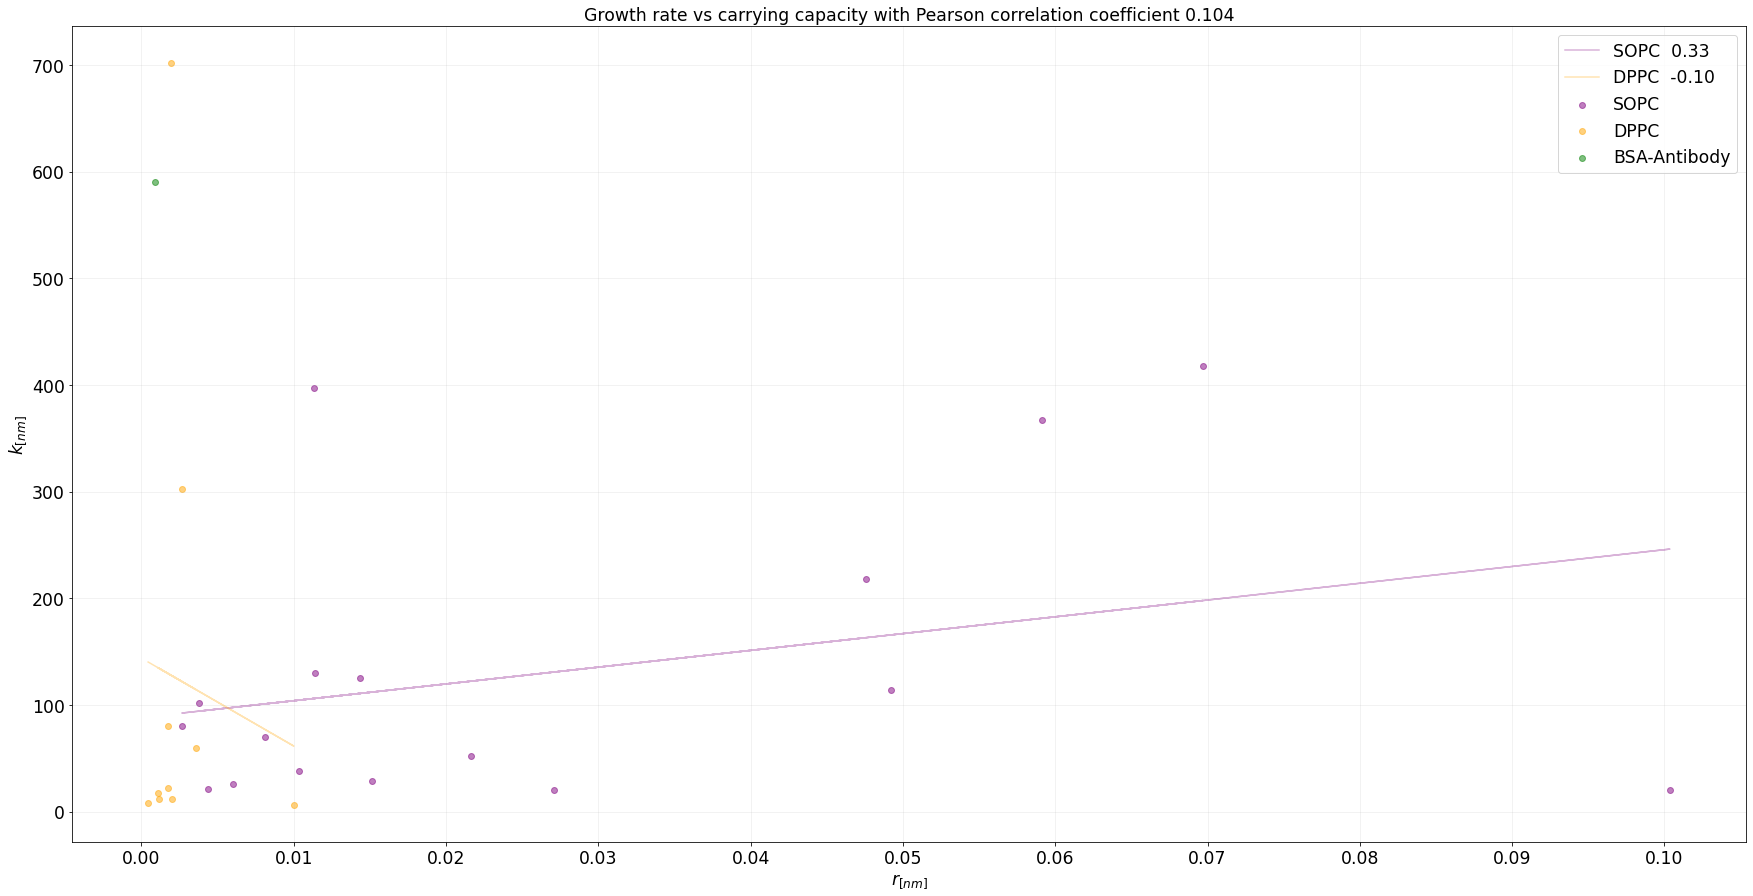

In [36]:
# Extract the logistic parameters excluding the DPPC curve
r = np.array([parameter[1] for parameter in df['Model_logistic'][:-1]])
k = np.array([parameter[2] for parameter in df['Model_logistic'][:-1]])
a = np.array([parameter[0] for parameter in df['Model_logistic'][:-1]])

# Calculate the slope and intercept of the growth rate and carrying capacity
m, b = np.polyfit(r, k, 1)

# Calculate the Pearson correlation coefficient
p = np.corrcoef(r, k)[0][1]

# Plot the results
plt.figure(figsize=(30,15))

# Scatter the growth rate against the carrying capacity
plt.scatter(r[:17], k[:17], color='purple', alpha = 0.5, label='SOPC')
plt.scatter(r[17:-1], k[17:-1], color='orange', alpha = 0.5, label='DPPC')
plt.scatter(r[-1:], k[-1:], color='green', alpha = 0.5, label='BSA-Antibody')


# Annotate each data point with it's index and initial area
#for i, A in enumerate(a): plt.annotate(f'[{i}]  {A:.1f}', (r[i], k[i]), fontsize='large')

# plot the fitted line between the data points
m, b = np.polyfit(r[:17], k[:17], 1)
plt.plot(r[:17], m*r[:17] + b, color='purple', alpha = 0.3, label=f'SOPC  {np.corrcoef(r[:17], k[:17])[0][1]:.2f}')

m, b = np.polyfit(r[17:-1], k[17:-1], 1)
plt.plot(r[17:-1], m*r[17:-1] + b, color='orange', alpha = 0.3, label=f'DPPC  {np.corrcoef(r[17:-1], k[17:-1])[0][1]:.2f}')

plt.xlabel('$r_{[nm]}$', fontsize='xx-large')
plt.ylabel('$k_{[nm]}$', fontsize='xx-large')
plt.title(f'Growth rate vs carrying capacity with Pearson correlation coefficient {p:.3f}', fontsize='xx-large')
plt.xticks(np.arange(0,0.11,0.01), fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)
plt.legend(fontsize='xx-large')

plt.savefig('Results/Growth_rate_vs_carrying_capacity')

### Plot a histogram for the growth rate and the carrying capacity

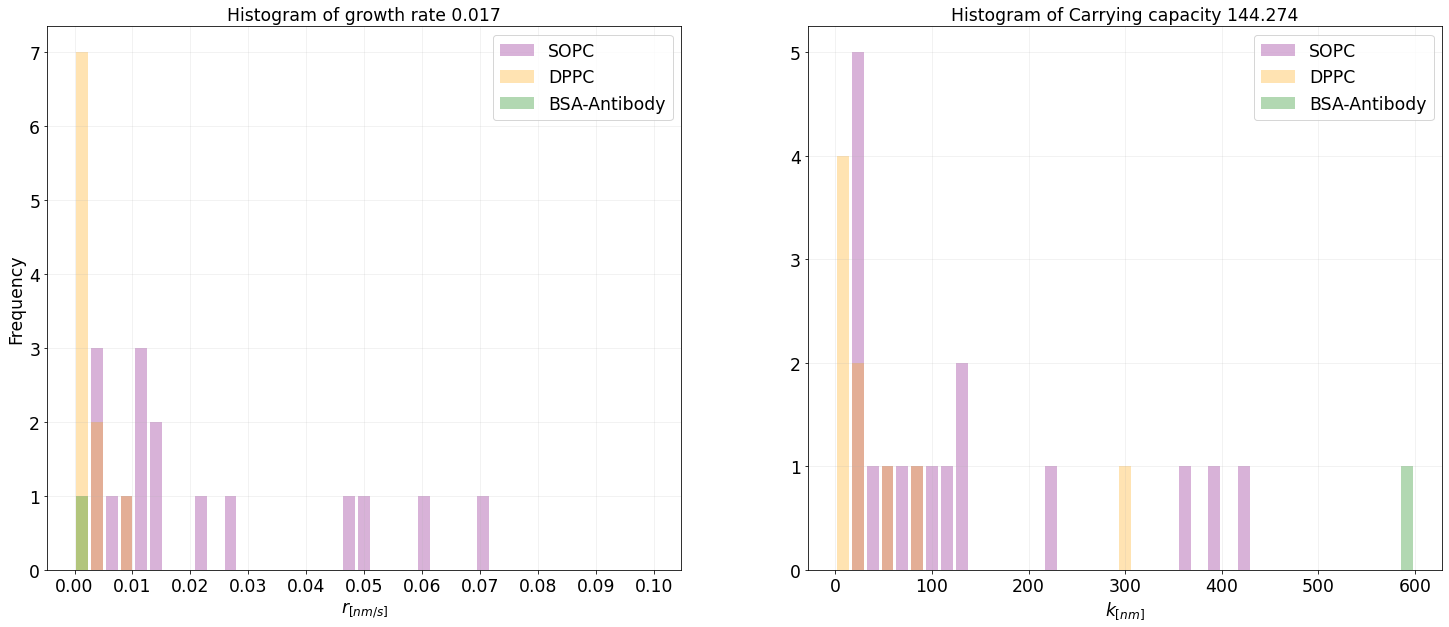

In [38]:
# Plot the results
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.hist(r[:17], bins=np.linspace(0,0.1,40), alpha=0.3, color = 'purple', label='SOPC', rwidth=0.8)
plt.hist(r[17:-1], bins=np.linspace(0,0.1,40), alpha=0.3, color = 'orange', label='DPPC', rwidth=0.8)
plt.hist(r[-1:], bins=np.linspace(0,0.1,40), alpha=0.3, color = 'green', label='BSA-Antibody', rwidth=0.8)
plt.xlabel('$r_{[nm/s]}$', fontsize='xx-large')
plt.ylabel('Frequency', fontsize='xx-large')
plt.title(f'Histogram of growth rate {r.mean():.3f}', fontsize='xx-large')
plt.xticks(np.arange(0,0.11,0.01), fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)
plt.legend(fontsize='xx-large')

plt.subplot(1,2,2)
plt.hist(k[:17], bins=np.linspace(0,600,40), alpha=0.3, color = 'purple', label='SOPC', rwidth=0.8)
plt.hist(k[17:-1], bins=np.linspace(0,600,40), alpha=0.3, color = 'orange', label='DPPC', rwidth=0.8)
plt.hist(k[-1:], bins=np.linspace(0,600,40), alpha=0.3, color = 'green', label='BSA-Antibody', rwidth=0.8)
plt.xlabel('$k_{[nm]}$', fontsize='xx-large')
#plt.ylabel('Frequency', fontsize='xx-large')
plt.title(f'Histogram of Carrying capacity {k.mean():.3f}', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)
plt.legend(fontsize='xx-large')

plt.savefig('Results/Growth_rate_and_carrying_capacity histograms')

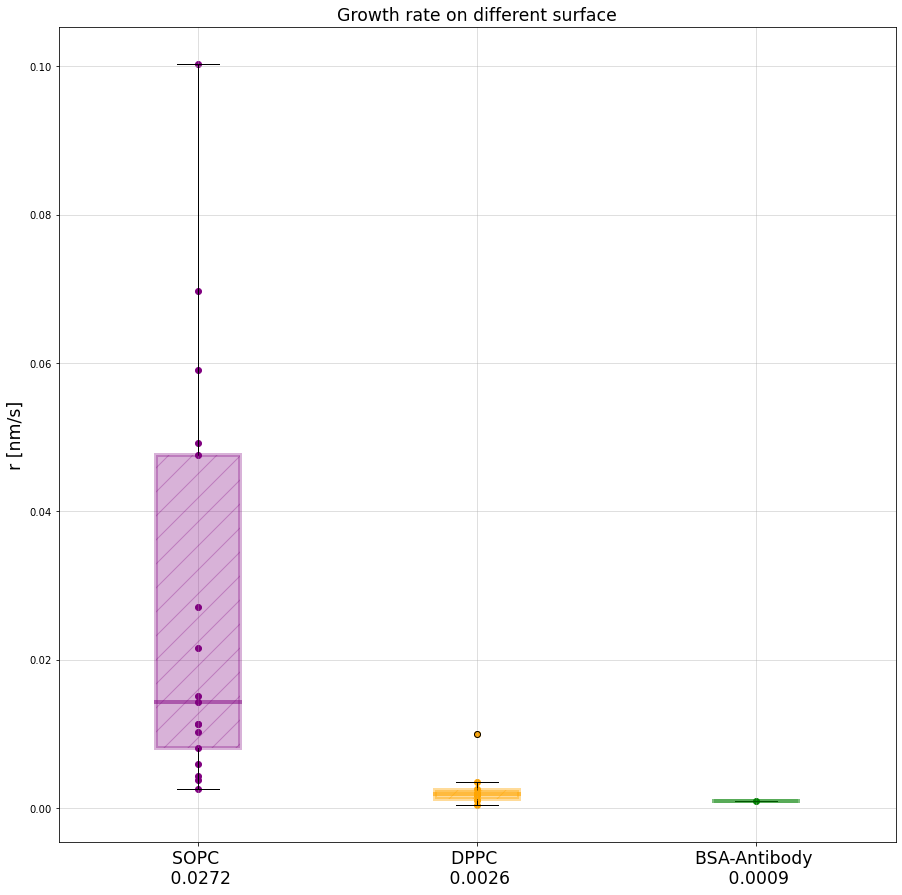

In [52]:
plt.figure(figsize=(15,15))

bp = plt.boxplot([r[:17], r[17:-1], r[-1]],
                labels = [f'SOPC\n{r[:17].mean():.4f}', f'DPPC\n{r[17:-1].mean():.4f}', f'BSA-Antibody \n {r[-1:].mean():.4f}'],
                patch_artist=True);

plt.ylabel('r [nm/s]', fontsize= 'xx-large')
#plt.xlabel('Surface', fontsize= 'xx-large')
plt.xticks(fontsize= 'xx-large')
plt.title('Growth rate on different surface', fontsize= 'xx-large')
plt.grid(alpha=0.5)

bp['boxes'][0].set(color = 'purple', hatch = '/', linewidth=4, alpha = 0.3)
bp['boxes'][1].set(color = 'orange', hatch = '/', linewidth=4, alpha = 0.4)
bp['boxes'][2].set(color = 'green', hatch = '/', linewidth=4, alpha = 0.3)

bp['medians'][0].set(color = 'purple', linewidth=4, alpha = 0.5)
bp['medians'][1].set(color = 'orange', linewidth=4, alpha = 0.6)
bp['medians'][2].set(color = 'green', linewidth=4, alpha = 0.5)
    
plt.scatter(x = [1] * len(r[:17]), y = r[:17], color='purple')
plt.scatter(x = [2] * len(r[17:-1]), y = r[17:-1], color='orange')
plt.scatter(x = [3], y = r[-1], color='green')

plt.savefig("Results/boxplot_growth_rate")

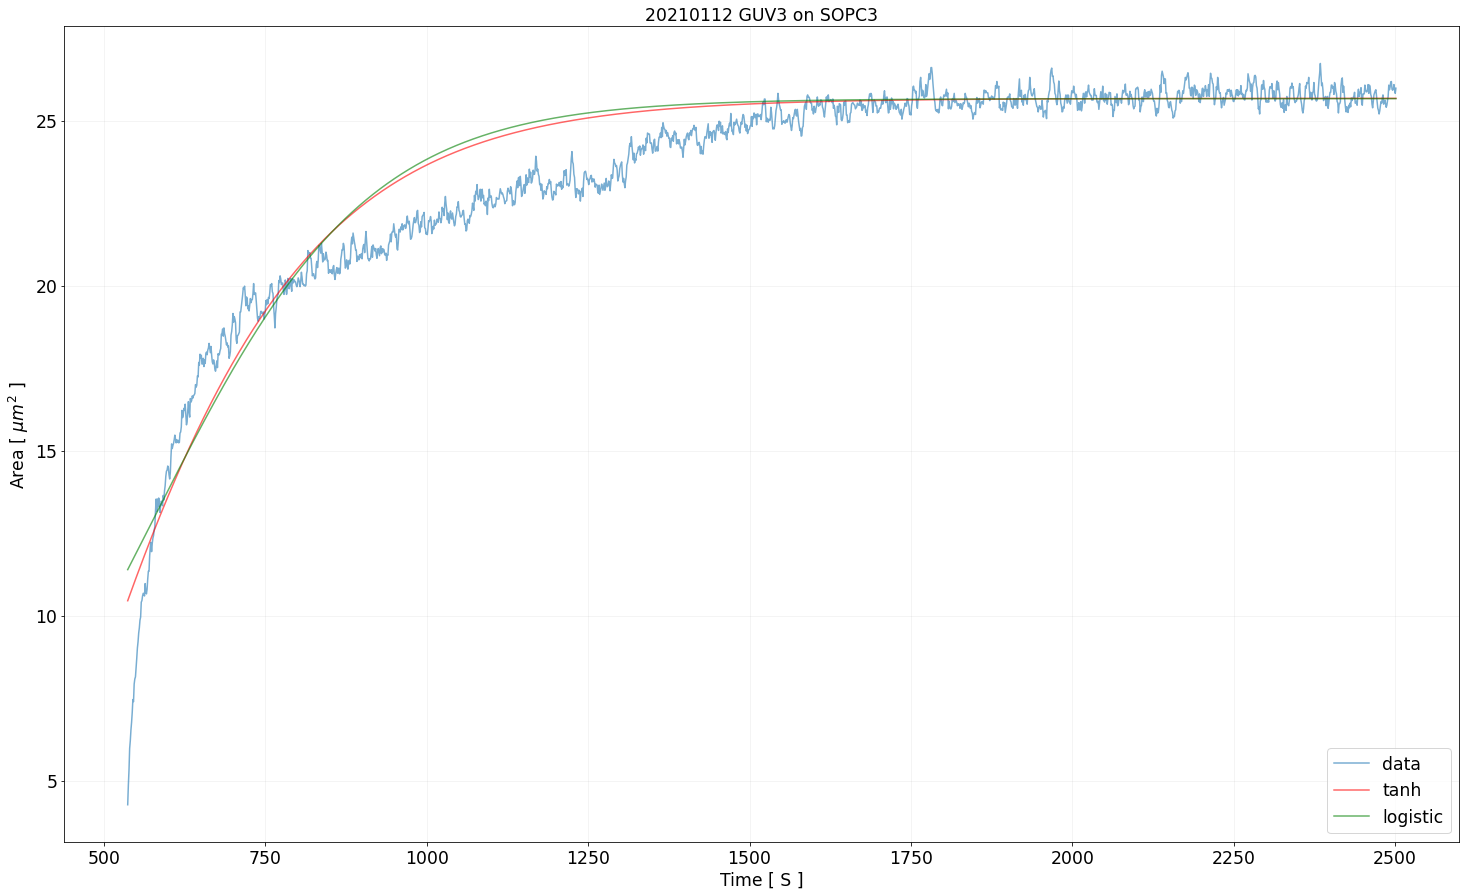

In [11]:
i = 6
df = pd.read_pickle('Results/manipulated_area_curves.pkl')

# Read the time and area
t, A = df['Time'][i], df['Area'][i]

# Create an array of weights
l = t.shape[0]
sigmas = np.ones(l) * (np.max(A)/50)
sigmas[:l//5] = sigmas[:l//5] * 0.1
sigmas[l-2*l//5:] = sigmas[l-2*l//5:] * 0.1
sigmas[l//5:l-2*l//5] = sigmas[l//5:l-2*l//5] * 5

# Fit a general tanh function to the curves 
popt_tanh, _ = curve_fit(area_tanh, t, A, sigma=sigmas,
                         p0=(np.max(A)-np.min(A), 0.01, 0, 0),
                         bounds=([0, 0.0001, 0, -np.max(A)], [np.max(A), 1, t[-1], 1.5*np.max(A)]))

# Fit a general tanh function to the curves 
popt_logistic, _ = curve_fit(area_logistic, t, A, sigma=sigmas,
                             p0=(1, 0.01, np.max(A)),
                             bounds=([0.1, 0.00001, np.min(A)], [np.min(A), 1, 2*np.max(A)]))

# Define the figure size only once
plt.figure(figsize=(25, 15))
plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')                # tanh
plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
plt.title(f'{df["Date"][i]} {df["Discription"][i]}', fontsize='xx-large')
plt.xlabel('Time [ S ]', fontsize='xx-large')
plt.ylabel('Area [ $\mu m^2$ ]', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(color = 'gray', alpha = 0.1)
plt.legend(loc='lower right', fontsize='xx-large')

#plt.savefig('area_curves_with_weights')

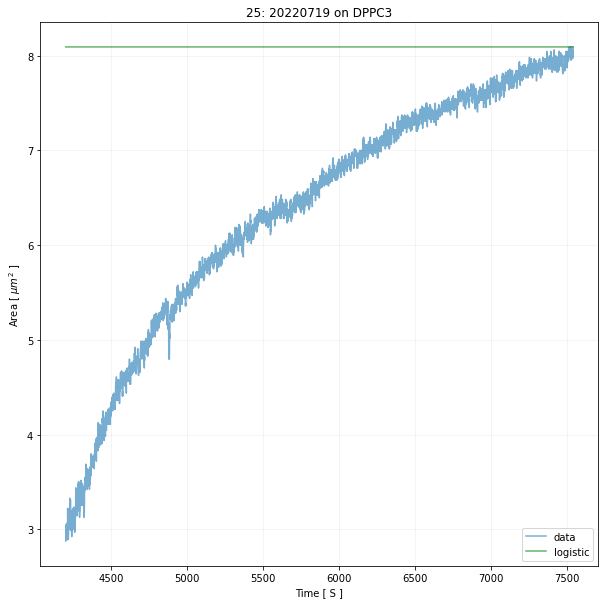

Column
    [0] Column
        [0] FloatSlider(end=2.5, name='a00', start=0.5, step=0.01, value=1)
        [1] FloatSlider(end=0.03, name='r0', start=-0.01, value=0.01)
        [2] FloatSlider(name='k0', step=0.01, value=1)
        [3] FloatSlider(end=0.30000000000000004, name='a0_min', start=-0.1, value=0.1)
        [4] FloatSlider(end=0.01, name='r_min', start=1e-05, step=1e-05, value=0.0001)
        [5] FloatSlider(name='k_min', step=0.01, value=1)
        [6] IntSlider(end=3, name='a0_max', start=-1, value=1)
        [7] FloatSlider(end=10, name='r_max', start=0.1, value=1)
        [8] IntSlider(end=6, name='k_max', start=-2, value=2)
    [1] Row
        [0] Str(None, name='interactive00101')

In [12]:
#@interact(a00=(1,100), r0=0.01, k0=1, a0_min=0.1, r_min=0.0001, k_min=1, a0_max=1, r_max=1, k_max=2)

def interactive_logistic_growth(a00=1, r0=0.01, k0=1, a0_min=0.1, r_min=0.0001, k_min=1, a0_max=1, r_max=1, k_max=2):

    df = pd.read_pickle('Results/manipulated_area_curves.pkl')

    i = 25

    # Read the time and area
    t, A = df['Time'][i], df['Area'][i]

    # Compute the maximum and minimum of the area
    area_max = np.max(A)
    area_min = np.min(A)

    # Fit a logistic growth function to the curves  k / (1 + (k/a0 - 1)*np.exp(-r*t)) with parameters a0, r, k
    popt_logistic, _ = curve_fit(area_logistic, t, A,
                                 p0=(a00, r0, k0*area_max),
                                 bounds=([a0_min, r_min, k_min*area_max], [a0_max*area_min, r_max, k_max*area_max]))

    # Define the figure size only once
    plt.figure(figsize=(10, 10))

    plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
    # plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')              # tanh
    plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right');
    return plt.show()

interact(interactive_logistic_growth, 
         a00=(0.5, 2.5, 0.01), 
         r0=0.01, 
         k0=(0, 1, 0.01), 
         a0_min=0.1, 
         r_min=(0.00001, 0.01, 0.00001), 
         k_min=(0, 1, 0.01), 
         a0_max=1, 
         r_max=(0.1, 10, 0.1), 
         k_max=2)